In [9]:
import sys
print(sys.version)

3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import pickle
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#tqdm.pandas()
from time import time

In [4]:
#read files

#description: https://www.kaggle.com/gspmoreira/news-portal-user-interactions-by-globocom

articles_metadata = pd.read_csv('data/articles_metadata.csv')
clicks_sample = pd.read_csv('data/clicks_sample.csv')


with open('data/articles_embeddings.pickle', 'rb') as pickle_file:
    embeddings = pickle.load(pickle_file)

In [5]:
print('articles_metadata')
display(articles_metadata.head())
print('clicks_sample')
display(clicks_sample.head())
print('embeddings shape')
print(embeddings.shape)

articles_metadata


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


clicks_sample


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


embeddings shape
(364047, 250)


In [5]:
def get_click_data():
    click_dir = 'data/clicks/clicks/'
    columns = ['user_id','click_article_id','click_environment','click_deviceGroup'] #validate with EDA
    return pd.concat(
        pd.read_csv(click_dir + click_data)[columns] for click_data in tqdm(listdir('data/clicks/clicks'))
    ).drop_duplicates()

In [6]:
# user_clicks = get_click_data()

In [7]:
display(user_clicks.head(),user_clicks.nunique())

,user_id,click_article_id,click_environment,click_deviceGroup
0,0,157541,4,3
1,0,68866,4,3
2,1,235840,4,1
3,1,96663,4,1
4,2,119592,4,1


user_id              322897
click_article_id      46033
click_environment         3
click_deviceGroup         5
dtype: int64

# Model 1: User Latent Vectors

In [6]:
df_x = pd.read_csv('data/df_x.csv',index_col=1)

In [7]:
df_x.head()

,user_id,click_article_id,env_device
0,1,285719,env:4 device:1
1,1,234481,env:4 device:1
2,1,235840,env:4 device:1
3,1,283392,env:4 device:1
4,1,36162,env:4 device:1


In [251]:
class LinearModel:
    def __init__(self, user_data, item_embeddings, size=8, embeddings_size=250, T=1):
        self.user_data = user_data
        self.item_embeddings = item_embeddings
        self.T = T
        self.Vd = LinearModel.d.get_embedding_vectors(
            item_embeddings, user_data, size, embeddings_size=embeddings_size
        )
        self.U = self.initialize_user_vectors(
            size=size,embeddings_size=embeddings_size
        )
        self.instantiate_errors()
        
    def initialize_user_vectors(self,size,embeddings_size=250):
        return np.mean(LinearModel.d.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size
        ),axis=1) #.repeat(size,axis=0).reshape(-1,size,embeddings_size)
        
    def instantiate_errors(self):
        #this is for tracking in steps of SGD
        self.errors = []
    
    #############################
    ###### SEEN AND UNSEEN ######
    #############################
    
    class d:
        @staticmethod
        def get_embedding_vectors(V_embeddings, df, size, embeddings_size=250):
            return np.hstack(V_embeddings[df.click_article_id.to_list()]).reshape(-1,size,embeddings_size)
    
    class dbar:
        @staticmethod
        def get_unseen(df, u, size, len_):
            return np.random.choice(
                np.delete(
                    np.arange(len_),
                    df[df.index.get_level_values(0)==u].click_article_id,
                ),
                size=size,
            )
        
        @staticmethod
        def get_all_unseen(df, size, len_=364047):            
            #semi-vectorized version
            
            return df.user_id.drop_duplicates().map(
                lambda u: LinearModel.dbar.get_unseen(df, u, size, len_)
            )
            
#             return np.hstack(pd.DataFrame(
#                 df.index.get_level_values(0)
#             ).drop_duplicates().user_id.map(
#                 lambda u: LinearModel.dbar.get_unseen(df, u, size, len_)
#             ))
        
        @staticmethod
        def get_embedding_vectors(V_embeddings, df, size, embeddings_size=250, len_=36047):
            return np.hstack(
                V_embeddings[LinearModel.dbar.get_all_unseen(df,size,len_=len_).tolist()]
            ).reshape(
                -1,
                size,
                embeddings_size
            )
    
    #########################
    ##### SGD UTILITIES #####
    #########################
    
    class gradient: 
        @staticmethod
        def J(U,Vd,Vdbar, size=8, embedding_size=250,hinge_param=1):

            
            
#             return np.sum(
#                 np.multiply(
#                     hinge_param + np.tensordot(U,Vdbar,axes=(1,2))[0] - np.tensordot(U,Vd,axes=(1,2))[0] > 0,
#                     np.tensordot(U,Vdbar,axes=(1,2))[0] - np.tensordot(U,Vd,axes=(1,2))[0]
#                 )
#             )


            cost = hinge_param + np.tensordot(U,Vdbar,axes=(1,2))[0] - np.tensordot(U,Vd,axes=(1,2))[0]
            return np.sum(
                np.max(
                    [np.zeros((U.shape[0],size)), cost], axis = 0
                )
            )
        
        @staticmethod
        def dJ(U,Vd,Vdbar,size=8,embedding_size=250,hinge_param=1):
            #conditional derivitive
            
            return np.sum(
                (
                    hinge_param + np.tensordot(U,Vdbar,axes=(1,2))[0]
                    - np.tensordot(U,Vd,axes=(1,2))[0] < 0
                ).repeat(
                    embedding_size
                ).reshape(-1,size,embedding_size) * (Vdbar - Vd),
                axis=1
            )
    
    ##### STOCHASTIC GRADIENT DESCENT ####
    
    
    def SGD_vectorized(
        self,
        alpha=0.1,
        size=8,
        test_size=128,
        embeddings_size=250,
        test=True,
        hinge_param=1,
        iteration=0,
        max_iterations=500
    ):
        #Stochastic Gradient Descent

        #print('Vd', self.item_embeddings[0,0:10])
        
        #resample stuff
        Vdbar_small = LinearModel.dbar.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size,
        )

        self.U = self.U - alpha * self.__class__.gradient.dJ(
            self.U,
            self.Vd,
            Vdbar_small,
        ) #fix this
        
        
        while True:
            if test == True:
                Vdbar_big = self.__class__.dbar.get_embedding_vectors(
                    self.item_embeddings,
                    self.user_data,
                    test_size,
                    embeddings_size=embeddings_size,
                )
                
                J = self.__class__.gradient.J(
                    self.U,
                    self.Vd.repeat(test_size/size,axis=1),
                    Vdbar_big,
                    size=test_size,
                    embedding_size=250,
                    hinge_param=1
                )
                # the Vd reshape still needs to be fixed
                
                self.errors.append(J)
                
            if iteration == max_iterations:
                #stop iterating
                #display errors
                if test == True:
                    sns.lineplot(
                        x = range(len(self.errors)),
                        y = self.errors
                    )
                    plt.figure(figsize=(12,12))
                    plt.show()
                return self.U
            #print(iteration)
            iteration += 1
            return self.SGD_vectorized(
                alpha=alpha, 
                size=size,
                test_size=test_size,
                embeddings_size=embeddings_size,
                test=test, 
                hinge_param=hinge_param,
                iteration=iteration, 
                max_iterations=max_iterations)

In [252]:
lm = LinearModel(df_x,embeddings,size=8, embeddings_size=250, T=1)
print(lm.U.shape,lm.Vd.shape)

(100, 250) (100, 8, 250)


#### Test out Pipeline

[-0.26824254 -0.9636772  -0.28512946 -0.32596728 -0.34310314 -0.2655414
 -0.25597954  0.02330121  0.22115023 -0.15524353]


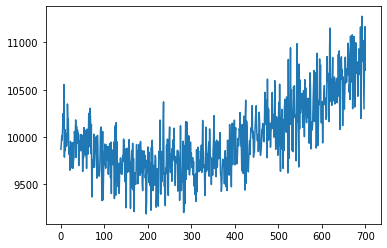

<Figure size 864x864 with 0 Axes>

[-0.27858853 -0.96210563 -0.49304053 -0.31543386 -0.67712885 -0.5008191
 -0.2792606   0.17000617  0.4142997  -0.29495686]


In [253]:
lm = LinearModel(df_x,embeddings,size=8, embeddings_size=250, T=1)
print(lm.U[0,0:10])
lm.SGD_vectorized(test=True,alpha=0.0001, max_iterations=700, test_size=128)
print(lm.U[0,0:10])

The function minimizes at around 250 iterations.  From now on we'll just stop there for the linear model.

#### Predict Articles & Train/Test Validation

# Model 2: Multiple User Latent Vectors

In [276]:
class NonlinearModel(LinearModel):
    def initialize_user_vectors(self,size,embeddings_size):
        '''
        sets self.U in parent class __init__
        '''
        starting_vectors = LinearModel.d.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size
        )
        
        return NonlinearModel.Cluster.k_means(starting_vectors,self.T)
    
    
    class Cluster():
        @staticmethod
        def starting_centroids(points,T):
            #initialize centroids by randomly picking an item for each user
            starter_idx = np.random.rand(points.shape[0],T).argsort(axis=-1)[:,0:T,np.newaxis]
            return np.take_along_axis(
                points,
                starter_idx,
                axis=1
            )

        @staticmethod
        def closest_centroid(points, centroids):
            #find the closest centroid to each point
            return np.argmin(
                np.square(
                    np.sum(
                        np.square(points[:,:,np.newaxis] - centroids[:,np.newaxis]),
                        axis=3
                    ),
                ),
                axis=2
            )

        @staticmethod
        def move_centroids(points,closest,k):
            #find new centroid based on cluster center from cluster_centroid
            weights = np.equal(
                np.arange(k)[np.newaxis,:,np.newaxis],
                closest[:,np.newaxis,:]
            )

            weights = np.repeat(weights[:,:,:,np.newaxis],points.shape[2],axis=3)

            points = np.repeat(points[:,np.newaxis],k,axis=1)

            return np.average(
                points,
                weights = weights,
                axis=2
            )

        @staticmethod
        def k_means(starting_vectors,k):
            def iterative_kmeans(starting_vectors,old_centroids, new_centroids,k):
                while True:
                    if np.all(new_centroids == old_centroids):
                        return new_centroids
                    else:
                        old_centroids = new_centroids
                        new_centroids = NonlinearModel.Cluster.move_centroids(
                            starting_vectors,
                            NonlinearModel.Cluster.closest_centroid(
                                starting_vectors,
                                old_centroids
                                ),                                           
                            k,
                        )
                        iterative_kmeans(starting_vectors,old_centroids,new_centroids,k)
            starting_centroids = NonlinearModel.Cluster.starting_centroids(starting_vectors,k)
            return iterative_kmeans(
                starting_vectors,
                np.zeros(starting_centroids.shape),
                starting_centroids,
                k
            )
    

            
        
    class gradient():
        @staticmethod
        def argmax_indices(U,Vd):
            #get which interest unit per user, per item, is best for each of their relevant items, d
            #output of tensor dot should be 100 x 8 x 3
            #output of argmax should be 100 x 8
            return np.argmax(
                np.tensordot(
                    Vd,
                    U,
                    axes=(2,2)
                )[:,:,0],
                axis=2
            )
        
        @staticmethod
        def J(U,Vd,Vdbar, size=8, embedding_size=250,hinge_param=1):
            
            Ui = np.take_along_axis(
                U,
                NonlinearModel.gradient.argmax_indices(U,Vd)[:,:,np.newaxis],
                axis=1
            )
            
            
            cost = hinge_param + np.tensordot(Ui,Vdbar,axes=(1,2))[0] - np.tensordot(Ui,Vd,axes=(1,2))[0]
            
            
        @staticmethod
        def dJ(U,Vd,Vdbar,size=8,embedding_size=250,hinge_param=1):
            
            argmax_indices = NonlinearModel.gradient.argmax_indices(U,Vd)
            
            Ui = np.take_along_axis(
                U,
                argmax_indices[:,:,np.newaxis],
                axis=1
            )
            
            print(Ui.shape)
            print(Vd.shape)
            
            #the part below needs fixing.
            #there may also be an additional problem with the tensordots... not sure.
            dJi = np.sum(
                (
                    hinge_param + np.tensordot(Ui,Vdbar,axes=(2,2))[0]
                    - np.tensordot(Ui,Vd,axes=(2,2))[0] < 0
                ).repeat(
                    embedding_size
                ).reshape(-1,size,embedding_size) * (Vdbar - Vd),
                axis=1
            )
            
            print(dJi.shape)
        
    def gradient_descent(self):
        pass

In [277]:
nm = NonlinearModel(df_x,embeddings,size=8, embeddings_size=250, T=3)
print(lm.U[0,0:10])
nm.SGD_vectorized(test=True,alpha=0.0001, max_iterations=1000, test_size=128)
print(lm.U[0,0:10])

[-0.27858853 -0.96210563 -0.49304053 -0.31543386 -0.67712885 -0.5008191
 -0.2792606   0.17000617  0.4142997  -0.29495686]
(100, 8, 250)
(100, 8, 250)


ValueError: operands could not be broadcast together with shapes (800,8,250) (100,8,250) 

# The Problem:
The gradient is not the appropriate shape for U in the non-linear model.  It's fit to the original shape for the nonlinear model.  Zeros need to be filled in for the unaffected interest units.  Fortunately, this only affects dJ and not J.